In [1]:
import pandas as pd


import numpy as np
import pandas as pd

import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

In [2]:
path = '/home/bhatti/dataset/VCHAMPS/procedures_train.csv'
procedures = pd.read_csv(path).iloc[:,1:]
procedures

,Internalpatientid,Age at procedure,Procedure date,Procedure code,Procedure code description,State
0,1,57.573116,2001-10-30 23:22:22.0,90658,"INFLUENZA VIRUS VACCINE, TRIVALENT (IIV3), SPL...",Indiana
1,1,57.573116,2001-10-30 23:22:22.0,90471,IMMUNIZATION ADMINISTRATION (INCLUDES PERCUTAN...,Indiana
2,1,57.573116,2001-10-30 23:22:22.0,99212,OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALU...,Indiana
3,1,57.912086,2002-03-03 20:49:01.0,84460,TRANSFERASE; ALANINE AMINO (ALT) (SGPT),Indiana
4,1,57.912086,2002-03-03 20:49:01.0,84450,TRANSFERASE; ASPARTATE AMINO (AST) (SGOT),Indiana
...,...,...,...,...,...,...
103020499,99999,95.894208,2012-10-22 07:59:26.0,98968,TELEPHONE ASSESSMENT AND MANAGEMENT SERVICE PR...,California
103020500,99999,96.029365,2012-12-10 17:35:21.0,99215,OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALU...,Arizona
103020501,99999,96.029365,2012-12-10 17:35:21.0,90935,HEMODIALYSIS PROCEDURE WITH SINGLE EVALUATION ...,Arizona
103020502,99999,96.324691,2013-03-28 16:11:17.0,99215,OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALU...,Arizona


Procedure code description: why the patient come to the hospital

In [3]:
#procedures[procedures.duplicated(subset = ['Internalpatientid', 'Procedure date','Procedure code description'], keep = False)]
procedures = procedures.drop_duplicates(subset = ['Internalpatientid', 'Procedure date','Procedure code description'], keep = 'first')

In [5]:
procedures.shape

(99254285, 6)

In [4]:
procedures.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99254285 entries, 0 to 103020503
Data columns (total 6 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   Internalpatientid           int64  
 1   Age at procedure            float64
 2   Procedure date              object 
 3   Procedure code              object 
 4   Procedure code description  object 
 5   State                       object 
dtypes: float64(1), int64(1), object(4)
memory usage: 5.2+ GB


In [7]:
procedures['Procedure code description'].nunique()

27744

In [8]:
for i in procedures['Procedure code description'].unique():
    print(i)

INFLUENZA VIRUS VACCINE, TRIVALENT (IIV3), SPLIT VIRUS, 0.5 ML DOSAGE,FOR INTRAMUSCULAR USE
IMMUNIZATION ADMINISTRATION (INCLUDES PERCUTANEOUS, INTRADERMAL, SUBCUTANEOUS,OR INTRAMUSCULAR INJECTIONS); 1 VACCINE (SINGLE OR COMBINATION VACCINE/TOXOID)
OFFICE OR OTHER OUTPATIENT VISIT FOR THE EVALUATION AND MANAGEMENT OF ANESTABLISHED PATIENT, WHICH REQUIRES A MEDICALLY APPROPRIATE HISTORY AND/OREXAMINATION AND STRAIGHTFORWARD MEDICAL DECISION MAKING. WHEN USING TIME FORCODE SELECTION, 10-19 MINUTES OF TOTAL TIME IS SPENT ON THE DATE OF THEENCOUNTER.
TRANSFERASE; ALANINE AMINO (ALT) (SGPT)
TRANSFERASE; ASPARTATE AMINO (AST) (SGOT)
LIPID PANELTHIS PANEL MUST INCLUDE THE FOLLOWING:CHOLESTEROL, SERUM, TOTAL (82465)LIPOPROTEIN, DIRECT MEASUREMENT, HIGH DENSITY CHOLESTEROL (HDLCHOLESTEROL) (83718)TRIGLYCERIDES (84478)
TELEPHONE CALL BY A PHYSICIAN TO PATIENT OR FOR CONSULTATION OR MEDICALMANAGEMENT OR FOR COORDINATING MEDICAL MANAGEMENT WITH OTHER HEALTHCARE PROFESSIONALS (EG, NURSES, THERAPIST

In [9]:
procedures = procedures.drop_duplicates(subset = ['Internalpatientid', 'Procedure date','Procedure code description'],keep = 'first')

In [11]:
procedures['num_procedure'] = procedures['Procedure code description'].groupby(procedures['Internalpatientid']).transform('count')

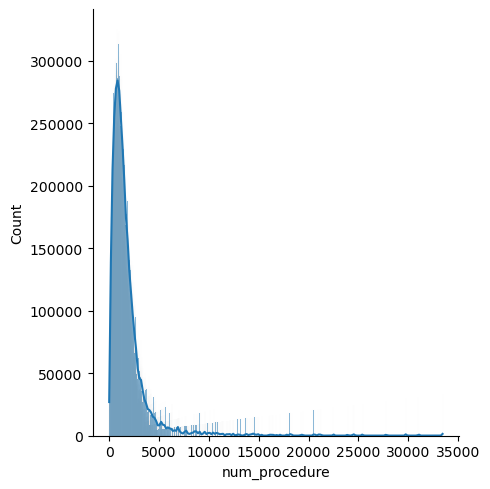

In [7]:
sns.displot(data=procedures, x='num_procedure', kde=True)

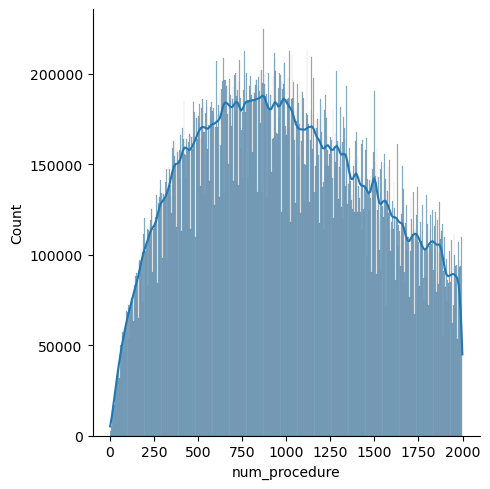

: 

In [8]:
sns.displot(data=procedures.loc[procedures['num_procedure'] < 2000], x='num_procedure', kde=True)

## Remove skewness

In [12]:
num_col = list(set(list(procedures._get_numeric_data().columns)))
num_col

['Age at procedure', 'Internalpatientid', 'num_procedure']

In [17]:
# Removing skewnewss and kurtosis using log transformation if it is above a threshold value -  2
def remove_skewness(df):
    statdataframe = pd.DataFrame()
    statdataframe['numeric_column'] = num_col
    skew_before = []
    skew_after = []

    kurt_before = []
    kurt_after = []

    standard_deviation_before = []
    standard_deviation_after = []

    log_transform_needed = []

    log_type = []

    for i in num_col:
        skewval = df[i].skew()
        skew_before.append(skewval)
        
        kurtval = df[i].kurtosis()
        kurt_before.append(kurtval)
        
        sdval = df[i].std()
        standard_deviation_before.append(sdval)
        
        if (abs(skewval) >2) & (abs(kurtval) >2):
            log_transform_needed.append('Yes')
            
            if len(df[df[i] == 0])/len(df) <=0.02:
                log_type.append('log')
                skewvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).skew()
                skew_after.append(skewvalnew)
                
                kurtvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).kurtosis()
                kurt_after.append(kurtvalnew)
                
                sdvalnew = np.log(pd.DataFrame(df[df[i] > 0])[i]).std()
                standard_deviation_after.append(sdvalnew)
                
            else:
                log_type.append('log1p')
                skewvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).skew()
                skew_after.append(skewvalnew)
            
                kurtvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).kurtosis()
                kurt_after.append(kurtvalnew)
                
                sdvalnew = np.log1p(pd.DataFrame(df[df[i] >= 0])[i]).std()
                standard_deviation_after.append(sdvalnew)
                
        else:
            log_type.append('NA')
            log_transform_needed.append('No')
            
            skew_after.append(skewval)
            kurt_after.append(kurtval)
            standard_deviation_after.append(sdval)

    statdataframe['skew_before'] = skew_before
    statdataframe['kurtosis_before'] = kurt_before
    statdataframe['standard_deviation_before'] = standard_deviation_before
    statdataframe['log_transform_needed'] = log_transform_needed
    statdataframe['log_type'] = log_type
    statdataframe['skew_after'] = skew_after
    statdataframe['kurtosis_after'] = kurt_after
    statdataframe['standard_deviation_after'] = standard_deviation_after
    return statdataframe

In [18]:
remove_skewness(procedures)

,numeric_column,skew_before,kurtosis_before,standard_deviation_before,log_transform_needed,log_type,skew_after,kurtosis_after,standard_deviation_after
0,Age at procedure,-0.120050,-0.114560,11.410931,No,NA,-0.120050,-0.114560,11.410931
1,Internalpatientid,-0.008273,-1.205484,48882.587112,No,NA,-0.008273,-1.205484,48882.587112
2,num_procedure,5.845554,50.704200,2339.384152,Yes,log,-0.279499,1.431079,0.903147


## Combine inpatient admission

In [7]:
procedures.columns

Index(['Internalpatientid', 'Age at procedure', 'Procedure date',
       'Procedure code', 'Procedure code description', 'State',
       'num_procedure'],
      dtype='object')

In [5]:
path = '/home/hassan/lily/MLA/FDA/inpatient_admission_withtarget.csv'
inpatient = pd.read_csv(path).iloc[:,1:]
inpatient_sub = inpatient[['Internalpatientid', 'Died during admission','Cardiovascular', 'Readmission']]

In [9]:
inpatient.columns

Index(['Internalpatientid', 'Age at admission', 'Admission date',
       'Discharge date', 'Admitting unit service', 'Discharging unit service',
       'Admitting specialty', 'Discharging specialty',
       'First listed discharge diagnosis icd10 subcategory',
       'Second listed discharge diagnosis icd10 subcategory',
       'Discharge disposition', 'Died during admission',
       'Outpatientreferralflag', 'Serviceconnectedflag', 'Agentorangeflag',
       'State', 'Cardiovascular', 'Readmission'],
      dtype='object')

In [6]:
inpatient_pro = inpatient_sub.merge(procedures[['Internalpatientid','num_procedure']], how = 'inner', on = 'Internalpatientid')
inpatient_pro = inpatient_pro.reset_index(drop = False)
inpatient_pro

: 

: 